In [1]:
import tensorflow as tf; tf.reset_default_graph()

init_x = tf.keras.initializers.constant(0.2)
init_y = tf.keras.initializers.constant(0.3)
x = tf.get_variable('x', (), tf.float32, init_x)
y = tf.get_variable('y', (), tf.float32, init_y)
f = x**2 + x*y + y**2
grads = tf.gradients(f, [x, y])
f_x = grads[0]
f_y = grads[1]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    print(sess.run([f, f_x, f_y]))    

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
[0.19000001, 0.70000005, 0.8]


In [2]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
print(type(housing))
print(dir(housing))

<class 'sklearn.utils.Bunch'>
['DESCR', 'data', 'feature_names', 'target']


In [3]:
print(housing.data.shape, housing.target.shape)

(20640, 8) (20640,)


In [4]:
import numpy as np
idx = np.arange(20640)
np.random.shuffle(idx)
x_train = housing.data[idx[:15000]] 
y_train = housing.target[idx[:15000]] 
x_test = housing.data[idx[15000:]] 
y_test = housing.target[idx[15000:]] 
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 8) (15000,)
(5640, 8) (5640,)


In [5]:
mu = np.mean(x_train, axis=0, keepdims=True)
sigma = np.std(x_train, axis=0, keepdims=True)
x_train = (x_train-mu)/sigma 
x_test = (x_test-mu)/sigma

In [6]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [7]:
epoch = int(1e3)
lr = 1e-2

In [8]:
m, n = x_train.shape # (15000, 8) m=15000, n=8
design_matrix = np.concatenate([np.ones((m, 1)), x_train], axis=1)
A = tf.constant(design_matrix, dtype=tf.float32, name="A")
x_train_tensor = tf.constant(x_train, dtype=tf.float32, name="x")
y_train_tensor = tf.constant(y_train.reshape((-1, 1)), dtype=tf.float32, name="y")
AT = tf.transpose(A)

In [9]:
init_theta = tf.keras.initializers.VarianceScaling(mode='fan_avg')
theta = tf.get_variable("theta", [n + 1, 1], tf.float32, init_theta)
theta_w = theta[1:,:] 
theta_b = theta[0,:]
y_train_pred = x_train_tensor@theta_w + theta_b

In [10]:
error = y_train_pred - y_train_tensor
loss = tf.reduce_mean(tf.square(error), name="loss")

In [11]:
if 0:
    # use mathematical formula
    gradients = 2/m * (AT@error)
    train = tf.assign(theta, theta - lr * gradients)
elif 0:
    # use tf.gradients 
    gradients = tf.gradients(loss, [theta])[0] 
    train = tf.assign(theta, theta - lr * gradients)
elif 1:
    # use train optimizer
    opt = tf.train.GradientDescentOptimizer(lr)
    train = opt.minimize(loss)    

In [12]:
x = tf.placeholder(tf.float32, [None, 8])
y_pred = x@theta_w + theta_b

In [13]:
init = tf.global_variables_initializer()

In [14]:
with tf.Session() as sess:
    sess.run(init)
    loss_trace = []
    for _ in range(epoch):
        loss_run, _ = sess.run([loss, train])
        loss_trace.append(loss_run)
    feed_dict = {x: x_test}
    y_test_pred = sess.run(y_pred, feed_dict=feed_dict)

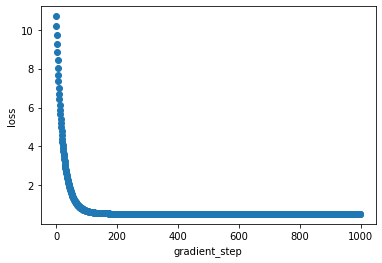

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_trace, 'o')
plt.xlabel('gradient_step')
plt.ylabel('loss')
plt.show()

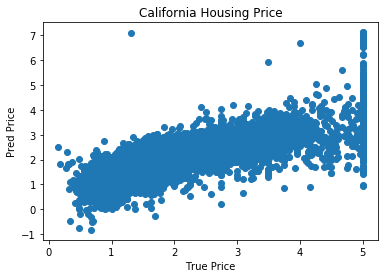

In [16]:
import matplotlib.pyplot as plt
plt.plot(y_test, y_test_pred, 'o')
plt.xlabel('True Price')
plt.ylabel('Pred Price')
plt.title('California Housing Price')
plt.show()

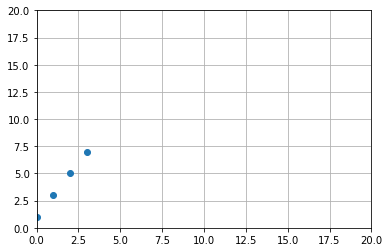

In [140]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
x_data = np.arange(4).astype(np.float32).reshape((-1,1))
y_data = 2 * x_data + 1
plt.plot(x_data.reshape((-1,)), y_data.reshape((-1,)), 'o')
plt.xlim([0,20])
plt.ylim([0,20])
plt.grid()
plt.show()

In [141]:
import tensorflow as tf; tf.reset_default_graph()

In [142]:
epoch = int(1e3)
lr = 1e-3

In [143]:
init_al = tf.keras.initializers.zeros()
init_bt = tf.keras.initializers.constant(0.1)
al = tf.get_variable("al", (), tf.float32, init_al)
bt = tf.get_variable("bt", (), tf.float32, init_bt)

In [144]:
x = tf.placeholder(tf.float32, [None, 1])
y = tf.placeholder(tf.float32, [None, 1])

In [145]:
y_pred = al + x * bt # (?, 1)
loss = tf.nn.l2_loss(y_pred-y)    

In [146]:
if 0:
    opt = tf.train.GradientDescentOptimizer(lr)
    train = opt.minimize(loss)
elif 0:
    tf.add_to_collection('beta', bt)
    var_list = tf.get_collection('beta')
    opt = tf.train.GradientDescentOptimizer(lr)
    train = opt.minimize(loss, var_list=var_list)
elif 1:
    tf.add_to_collection('alpha', al)
    var_list = tf.get_collection('alpha')
    opt = tf.train.GradientDescentOptimizer(lr)
    train = opt.minimize(loss, var_list=var_list)

In [147]:
init = tf.global_variables_initializer()

In [148]:
with tf.Session() as sess:
    sess.run(init)
    loss_trace = []
    for _ in range(epoch):
        feed_dict = {x: x_data, y: y_data}
        loss_run, _ = sess.run([loss, train], feed_dict=feed_dict)
        loss_trace.append(loss_run)
    feed_dict = {x: x_data}
    y_data_pred = sess.run(y_pred, feed_dict=feed_dict)
    print(sess.run([al, bt]))

[3.7800481, 0.1]


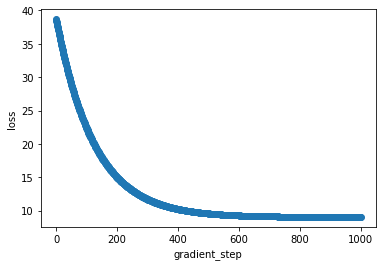

In [149]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_trace, 'o')
plt.xlabel('gradient_step')
plt.ylabel('loss')
plt.show()

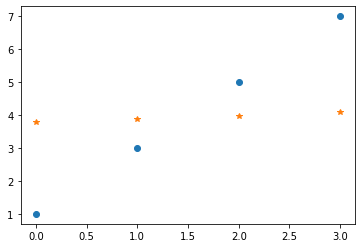

In [150]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(x_data.reshape((-1,)), y_data.reshape((-1,)), 'o')
plt.plot(x_data.reshape((-1,)), y_data_pred.reshape((-1,)), '*')
plt.show()

In [163]:
import tensorflow as tf
import numpy as np
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32).reshape(-1, 28*28) / 255.0
x_test = x_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
x_valid, x_train = x_train[:5000], x_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [164]:
def shuffle_batch(x, y, batch_size):
    rnd_idx = np.random.permutation(len(x))
    n_batches = len(x) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        x_batch, y_batch = x[batch_idx], y[batch_idx]
        yield x_batch, y_batch

In [165]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [166]:
lr = 1e-2
epoch = 20
batch_size = 200
threshold = 1.0

In [167]:
n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

x = tf.placeholder(tf.float32, shape=(None, n_inputs), name="x")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.variable_scope("dnn"):
    hidden1 = tf.layers.dense(x, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.variable_scope("loss"):
    entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(entropy, name="loss")

In [168]:
opt = tf.train.GradientDescentOptimizer(lr)
grads_and_vars = opt.compute_gradients(loss)
if 1:
    grads_and_vars = [(tf.clip_by_value(grad, -threshold, threshold), var)
                      for grad, var in grads_and_vars]
train = opt.apply_gradients(grads_and_vars)
# train = opt.minimize(loss)

In [169]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [170]:
init = tf.global_variables_initializer()

In [171]:
with tf.Session() as sess:
    init.run()
    for i in range(epoch):
        for x_batch, y_batch in shuffle_batch(x_train, y_train, batch_size):
            sess.run(train, feed_dict={x: x_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={x: x_valid, y: y_valid})
        print(i, "Validation accuracy:", accuracy_val)

0 Validation accuracy: 0.5998
1 Validation accuracy: 0.8308
2 Validation accuracy: 0.8762
3 Validation accuracy: 0.908
4 Validation accuracy: 0.9144
5 Validation accuracy: 0.9252
6 Validation accuracy: 0.929
7 Validation accuracy: 0.9346
8 Validation accuracy: 0.9394
9 Validation accuracy: 0.9448
10 Validation accuracy: 0.9446
11 Validation accuracy: 0.9488
12 Validation accuracy: 0.9498
13 Validation accuracy: 0.9504
14 Validation accuracy: 0.955
15 Validation accuracy: 0.9544
16 Validation accuracy: 0.9562
17 Validation accuracy: 0.9578
18 Validation accuracy: 0.9598
19 Validation accuracy: 0.9602
